## Global Black Box Optimization with RNNS

In [1]:
import tensorflow as tf
import numpy as np
import visualize as viz

In [2]:
def kernel(x1,x2,l = 0.3):
    return np.exp(-1.0/l**2*np.sum((np.expand_dims(x1,axis=2) - np.expand_dims(x2,axis=1))**2, axis = 3))

def GP(X,A,x, l = 0.3):
    k_xX = kernel(x,X)
    return np.squeeze(np.matmul(k_xX,  A),axis=(2,))

def kernelTF(x1,x2,l = 0.3):
    return tf.exp(-1.0/l**2*tf.reduce_sum((tf.expand_dims(x1,axis=2) - tf.expand_dims(x2,axis=1))**2, axis = 3))

def GPTF(X,A,x, l = 0.3):
    k_xX = kernelTF(tf.expand_dims(x, axis = 1),X)
    return tf.squeeze(tf.matmul(k_xX,  A),axis=(2,))

def normalize(minv, maxv, y):
    return 2*(y-minv)/(maxv-minv)-1.0

In [3]:
def gen_data(n_train, n_test, dim, n_gp_samples, n_mc_samples = 100):
    X = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples, dim))
    Y = np.random.uniform(low = -1.0, high = 1.0, size = (n_train+n_test, n_gp_samples))

    K_XX = kernel(X,X)
    A = np.linalg.solve(K_XX, np.expand_dims(Y,axis=2))
    
    mc_samples = np.random.uniform(low = -1.0, high = 1.0, size = [1, n_mc_samples, dim])
    y = GP(X,A,mc_samples)

    min_vals = np.min(y, axis = 1).reshape(n_train+n_test,1)
    max_vals = np.max(y, axis = 1).reshape(n_train+n_test,1)

    return (X[:n_train], A[:n_train], min_vals[:n_train], max_vals[:n_train],\
            X[-n_test:], A[-n_test:], min_vals[-n_test:], max_vals[-n_test:])

In [4]:
def lstm_model(f):
    weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, dim]))
    }
    biases = {
    'out': tf.Variable(tf.random_normal([dim]))
    }
    
    x_0 = -0.0*tf.ones([size, dim])
    h_0 = tf.ones([size, n_hidden])
    c_0 = tf.ones([size, n_hidden])
    
    state = (c_0, h_0)
    x = x_0
    y = f(x)
    samples_x = [x]
    samples_y = [y]

    # No idea why this is necessary 
    cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=None)
    cell(tf.concat([x, y], 1), state, scope='rnn_cell')
    cell = tf.contrib.rnn.LSTMCell(num_units = n_hidden, reuse=True)

    for i in range(n_steps):
        h, state = cell(tf.concat([x, y], 1), state, scope='rnn_cell')
        x = tf.tanh(tf.matmul(h, weights['out']) + biases['out'])
        y = f(x)
        
        samples_x.append(x)
        samples_y.append(y)
    
    return samples_x, samples_y

In [5]:
def train_model(epochs, batch_size, log = True, verbose = True):
    
    if log:
        train_loss_list = []
        test_loss_list = []
        train_fmin_list = []
        test_fmin_list = []
    
    if verbose:
        print("Function Dimension: \t\t"+str(dim))
        print("Number of Training Samples: \t"+str(n_train))
        print("Number of Test Samples: \t"+str(n_test))
        print("Batch size: \t\t\t"+str(batch_size))
        print("Number of hidden Units: \t"+str(n_hidden))
        print("Sequence length: \t\t"+ str(n_steps))
        print("Loss-Function: \t\t\t" + loss_type)
        print("Epochs: \t\t\t"+str(epochs))
        print("Learning rate: \t\t\t"+str(learning_rate))
        print("------------------------------------------------------------------------------------")

    for ep in range(epochs):
        for batch in range(n_train//batch_size):
            X_batch = X_train[batch*batch_size:(batch+1)*batch_size]
            A_batch = A_train[batch*batch_size:(batch+1)*batch_size]
            min_batch = min_train[batch*batch_size:(batch+1)*batch_size]
            max_batch = max_train[batch*batch_size:(batch+1)*batch_size]

            sess.run([train_step],\
                     feed_dict={Xt: X_batch, At: A_batch, mint: min_batch, maxt: max_batch, size: X_batch.shape[0]})

        if log:
            train_loss, train_fmin = sess.run([loss, f_min], feed_dict=\
                                              {Xt: X_train, At: A_train, mint: min_train, maxt: max_train, size: n_train})
            test_loss, test_fmin = sess.run([loss, f_min], feed_dict=\
                                              {Xt: X_test, At: A_test, mint: min_test, maxt: max_test, size:n_test})
            train_loss_list += [train_loss]
            test_loss_list += [test_loss]
            train_fmin_list += [train_fmin]
            test_fmin_list += [test_fmin]

        if log and verbose and (ep < 10 or ep % (epochs // 10) == 0 or ep == epochs-1):
            print("Ep: " +"{:4}".format(ep)+" | TrainLoss: "+"{: .3f}".format(train_loss)
                  +" | TrainMin: "+ "{: .3f}".format(train_fmin)+ " | TestLoss: "+
                  "{: .3f}".format(test_loss)+" | TestMin: "+ "{: .3f}".format(test_fmin))
    
    print("Done.")
    if log:
        return (train_loss_list, test_loss_list, train_fmin_list, test_fmin_list)
    return None

In [6]:
# Data
n_train = 1600
n_test = 1600
n_gp_samples = 8
n_mc_samples = 1000
dim = 1

# LSTM Model
n_hidden = 50
n_steps = 20

# Optimization
learning_rate = 0.0001
epochs = 100
batch_size = 160
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "EI"][3]

# Visualization
visualize = True

In [7]:
X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    gen_data(n_train, n_test, dim, n_gp_samples, n_mc_samples)

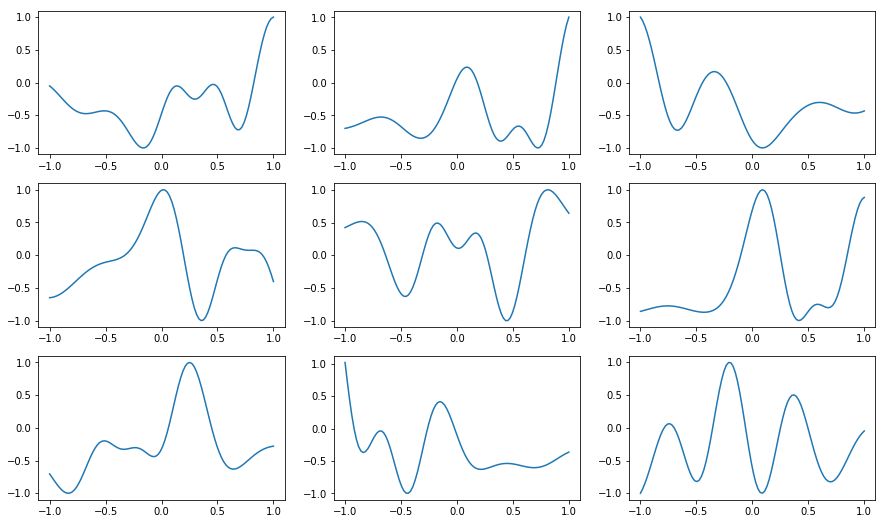

In [8]:
# Visualize Training Data
if visualize:
    nplot = 9
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_training_data(f_plot, dim, nplot, heat = True)

In [9]:
# Create Model
size = tf.placeholder(tf.int32,[])

Xt = tf.placeholder(tf.float32, [None, n_gp_samples, dim])
At = tf.placeholder(tf.float32, [None, n_gp_samples, 1])
mint = tf.placeholder(tf.float32, [None, 1])
maxt = tf.placeholder(tf.float32, [None, 1])

f = lambda x: normalize(mint, maxt, GPTF(Xt, At, x)) 

samples_x, samples_y = lstm_model(f)

In [10]:
f_min = tf.reduce_mean(tf.reduce_min(samples_y, axis = 0))

loss_dict = {"MIN" : lambda x : tf.reduce_mean(tf.reduce_min(x, axis = 0)), 
             "SUM" : lambda x : tf.reduce_mean(tf.reduce_sum(x, axis = 0)),
             "WSUM" : lambda x : \
             tf.reduce_mean(tf.reduce_sum(tf.multiply(x, np.linspace(1/(n_steps+1),1, n_steps+1)), axis = 0)),
             "EI" : lambda x : tf.reduce_mean(tf.reduce_sum(x, axis = 0)) -\
                               tf.reduce_mean(tf.reduce_sum([tf.reduce_min(x[:i+1],\
                               axis = 0) for i in range(n_steps)], axis = 0))
            }
loss = loss_dict[loss_type](samples_y)

In [11]:
train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [12]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [13]:
train_loss_list, test_loss_list, train_fmin_list, test_fmin_list = train_model(epochs, batch_size)

Function Dimension: 		1
Number of Training Samples: 	1600
Number of Test Samples: 	1600
Batch size: 			160
Number of hidden Units: 	50
Sequence length: 		20
Loss-Function: 			EI
Epochs: 			100
Learning rate: 			0.0001
------------------------------------------------------------------------------------
Ep:    0 | TrainLoss:  6.581 | TrainMin: -0.382 | TestLoss:  6.706 | TestMin: -0.359
Ep:    1 | TrainLoss:  6.237 | TrainMin: -0.364 | TestLoss:  6.390 | TestMin: -0.340
Ep:    2 | TrainLoss:  6.024 | TrainMin: -0.351 | TestLoss:  6.201 | TestMin: -0.328
Ep:    3 | TrainLoss:  5.921 | TrainMin: -0.346 | TestLoss:  6.105 | TestMin: -0.322
Ep:    4 | TrainLoss:  5.891 | TrainMin: -0.347 | TestLoss:  6.072 | TestMin: -0.323
Ep:    5 | TrainLoss:  5.836 | TrainMin: -0.348 | TestLoss:  6.012 | TestMin: -0.324
Ep:    6 | TrainLoss:  5.771 | TrainMin: -0.350 | TestLoss:  5.940 | TestMin: -0.327
Ep:    7 | TrainLoss:  5.651 | TrainMin: -0.353 | TestLoss:  5.807 | TestMin: -0.331
Ep:    8 | TrainL

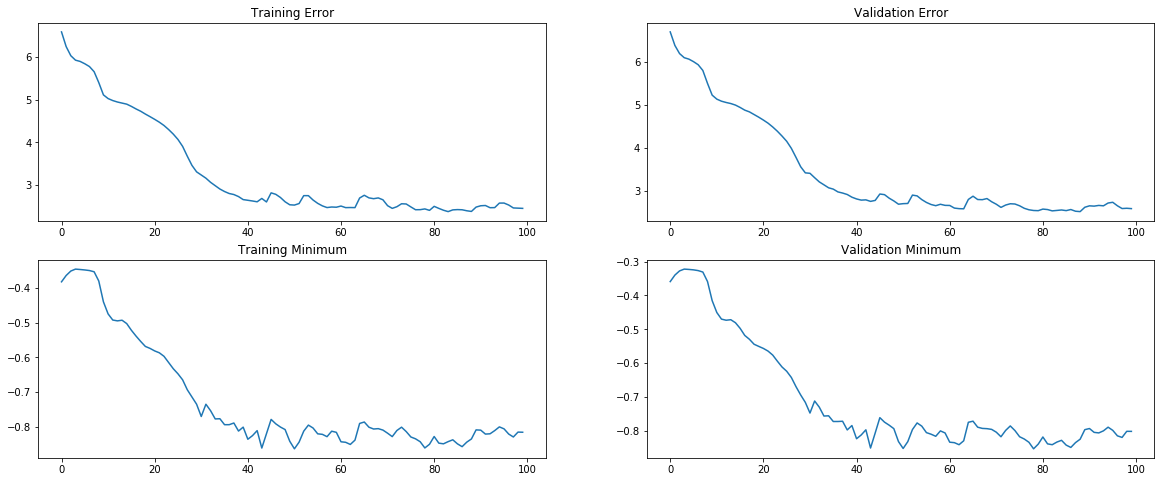

In [14]:
viz.visualize_learning(train_loss_list, test_loss_list, train_fmin_list, test_fmin_list)

In [15]:
# Extract Samples
samples_train = sess.run([samples_x], feed_dict={Xt: X_train, At: A_train, size : n_train, mint: min_train, maxt: max_train})
samples_train = np.array(samples_train[0]).reshape(n_steps+1,n_train, dim).transpose((1,0,2))
samples_test = sess.run([samples_x], feed_dict={Xt: X_test, At: A_test, size : n_test, mint: min_test, maxt: max_test})
samples_test = np.array(samples_test[0]).reshape(n_steps+1,n_test, dim).transpose((1,0,2))

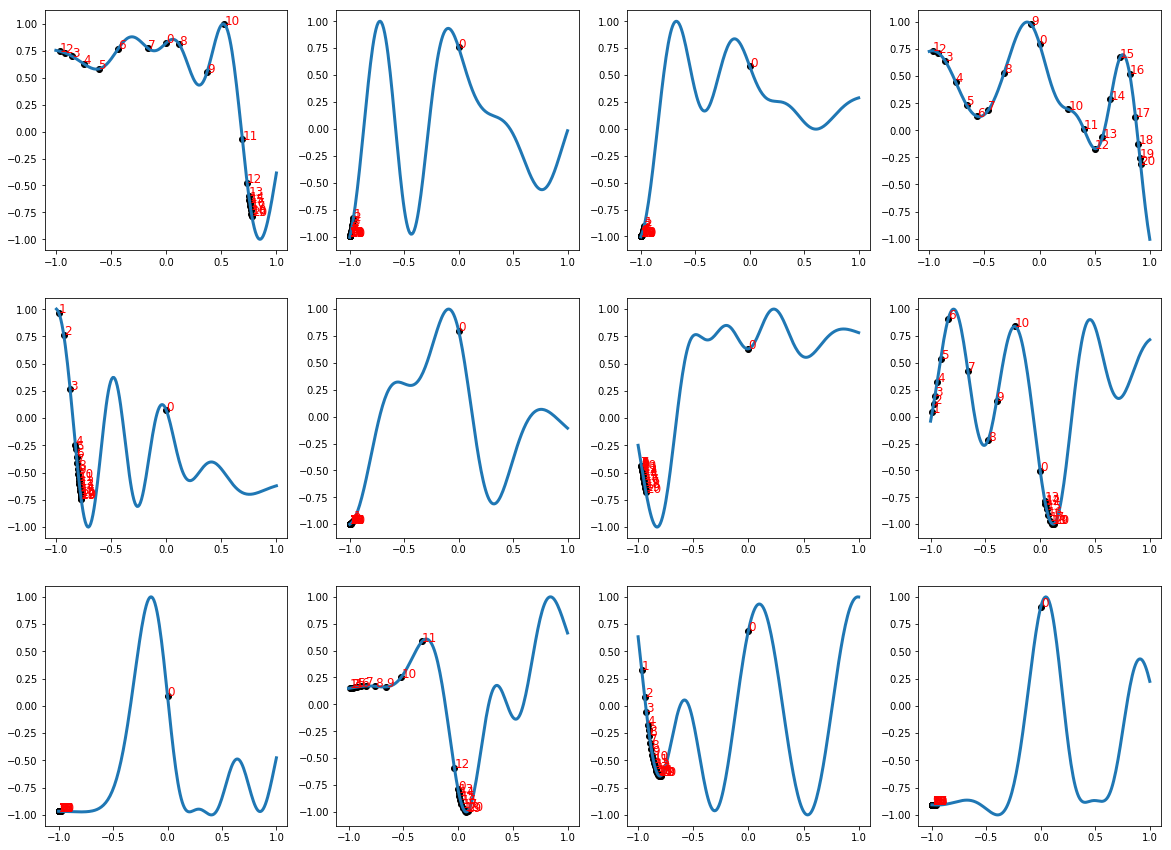

In [16]:
# Show results on Training Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_train)), nplot)
    f_plot = lambda x: normalize(min_train[idx], max_train[idx], GP(X_train[idx], A_train[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_train[idx])

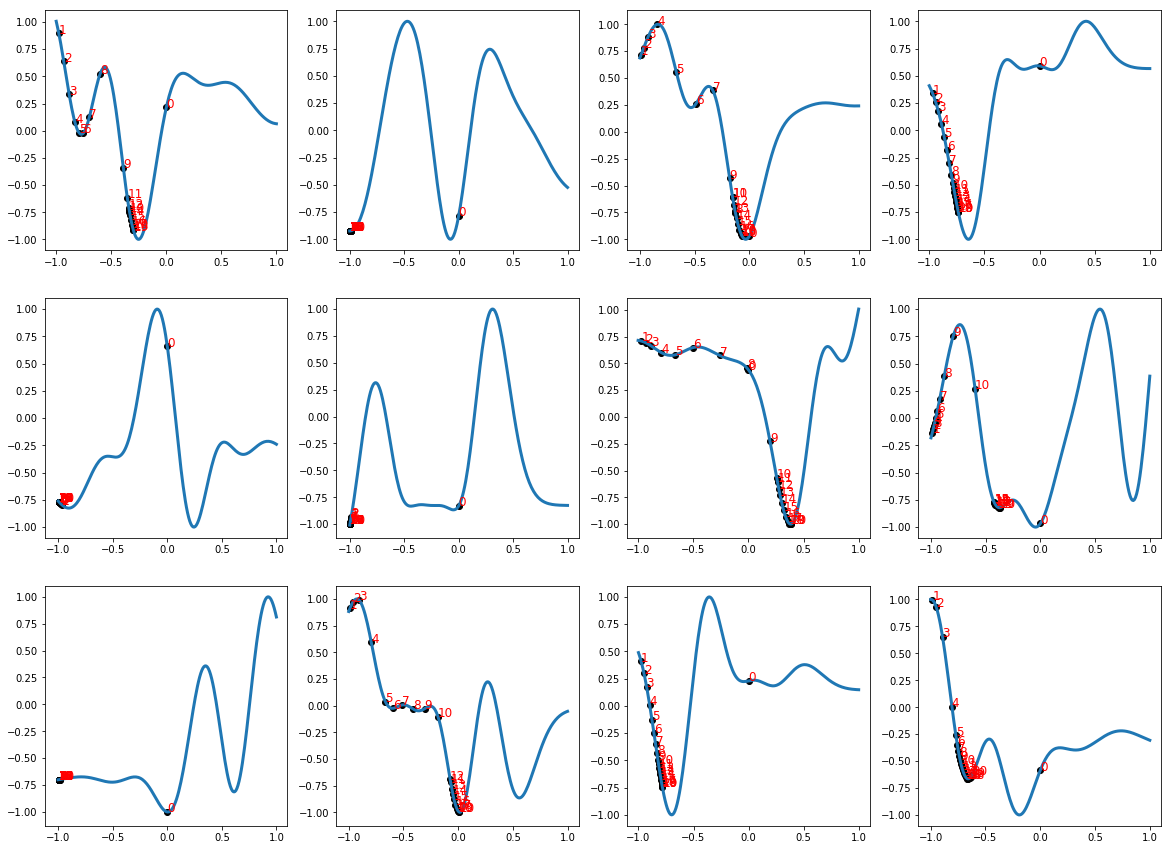

In [17]:
# Show results on Test Data
if visualize:
    nplot = 12
    idx = np.random.choice(list(range(n_test)), nplot)
    f_plot = lambda x: normalize(min_test[idx], max_test[idx], GP(X_test[idx], A_test[idx], x)) 
    viz.plot_result(f_plot, dim, nplot, samples_test[idx])